In [1]:
import pandas as pd
import matplotlib.pyplot  as plt
import os

In [2]:
ts = pd.read_csv('manual_30min_norm.csv')
validation = pd.read_csv("iiot_30min_norm.csv")

In [3]:
def data_split(ts, param="1", train_percentage=0.67):
    timeseries = ts[ts.columns[int(param)]].values.astype('float32')
    train_size = int(len(timeseries) * train_percentage)
    train, test = timeseries[:train_size], timeseries[train_size:]
    return train, test, timeseries

In [4]:
import torch

lookback = 1
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i:i + lookback]
        target = dataset[i + 1:i + lookback + 1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [5]:
train, test, total = data_split(ts)

X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

C:\Users\user\AppData\Local\Temp\ipykernel_11496\2883143177.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  return torch.tensor(X), torch.tensor(y)


In [6]:
import torch.nn as nn
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [7]:
import numpy as np
import torch.optim as optim
import torch.utils.data as torch_data
 
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = torch_data.DataLoader(torch_data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

EPOCHS = 20

In [8]:
def train_model(model, X_train, X_test, y_train, y_test, n_epochs):
    y_pred_train = None
    y_pred_test = None

    for epoch in range(1, n_epochs + 1):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 10 != 0 and epoch > 1:
            continue
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train)
            y_pred_train = y_pred
            train_rmse = np.sqrt(loss_fn(y_pred, y_train))
            y_pred = model(X_test)
            y_pred_test = y_pred
            test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
    return y_pred_train, y_pred_test, model

In [9]:
y_pred_train, y_pred_test, model = train_model(model, X_train, X_test, y_train, y_test, EPOCHS)

Epoch 1: train RMSE 0.0020, test RMSE 0.0021
Epoch 10: train RMSE 0.0019, test RMSE 0.0019
Epoch 20: train RMSE 0.0015, test RMSE 0.0016


In [10]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def validate(true, pred):
    true = pd.DataFrame(true.flatten().numpy())[0]
    pred = pd.DataFrame(pred.flatten().numpy())[0]
    print("MSE:", mean_squared_error(true, pred))
    print("RMSE:", sqrt(mean_squared_error(true, pred)))
    print("MAE:", mean_absolute_error(true, pred))
    print("MAPE:", mean_absolute_percentage_error(true, pred))
    print("R2:", r2_score(true, pred))

In [11]:
def plot_train_n_pred(X_train, X_test, total, model):
    with torch.no_grad():
        train_plot = np.ones_like(total) * np.nan
        y_pred = model(X_train)
        y_pred = y_pred[:, -1]
        train_size = len(X_train)
        train_plot[lookback:train_size + 1] = model(X_train)[:, -1]
        test_plot = np.ones_like(total) * np.nan
        test_plot[train_size + lookback:len(total) - 1] = model(X_test)[:, -1]

    plt.rcParams["figure.figsize"] = [12, 7]
    plt.plot(total, c='b')
    plt.plot(train_plot, c='r')
    plt.plot(test_plot, c='g')
    plt.show()

In [12]:
def validate_on_measurement(model):
    valid_train, valid_test, valid_total = data_split(validation)
                
    X_train, _ = create_dataset(valid_train, lookback=lookback)
    X_test, y_test = create_dataset(valid_test, lookback=lookback)

    y_pred = model(X_test)
    y_pred_test = y_pred
    
    print(f"Метрики:")
    try:
        validate(y_pred_test, y_test)
    except:
        validate(y_pred_test.detach(), y_test.detach())
    plot_train_n_pred(X_train, X_test, valid_total, model)

Метрики:
MSE: 0.0017595643
RMSE: 0.041947160466433514
MAE: 0.010274645
MAPE: 3.087388165295124
R2: 0.8328429151538581


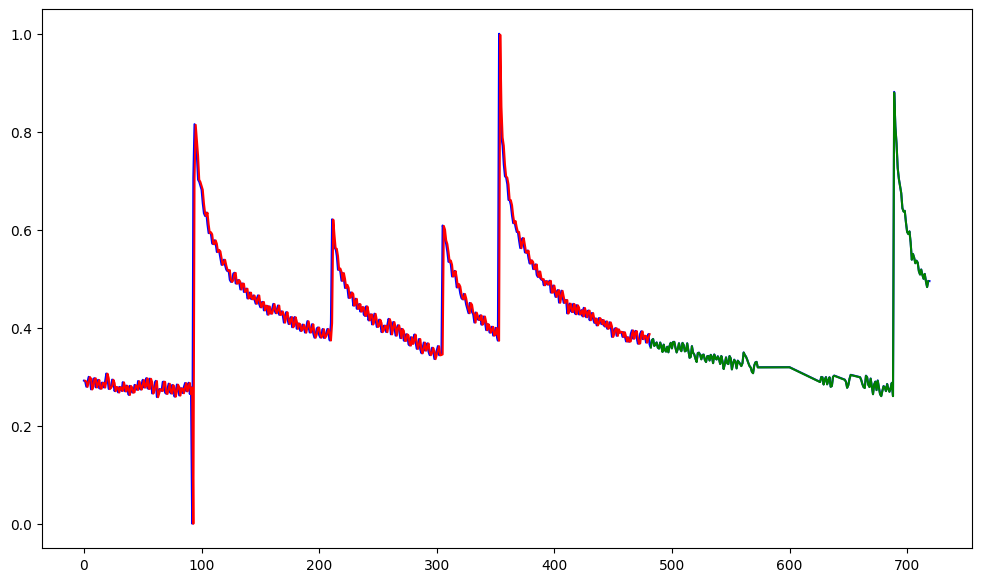

In [13]:
validate_on_measurement(model)